# Transfer Learning with PyTorch

In [24]:
# Handle to the workspace
from azure.ai.ml import MLClient
from azure.ai.ml import command, Input, Output
from azure.ai.ml.entities import Environment
from azure.ai.ml.entities import Data, Model
from azure.ai.ml.constants import AssetTypes

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

ml_client = MLClient(
    credential=credential,
    subscription_id = "431dbae5-40ca-438a-8daf-77d7d5580b41",
    resource_group_name = "Cybertron-RG",
    workspace_name = "Cybertron",
)

print("Connected to: "+ml_client.workspace_name)

Connected to: Cybertron


### Data

In [1]:
data = ml_client.data.get("LegoCharactersV2",2)

print("Name: ", data.name)
print("Description: ", data.description)
print("type: ", data.type)
print("Version: ", data.version)

NameError: name 'ml_client' is not defined

###  Compute

In [26]:
cpu_cluster = ml_client.compute.get("UltraMagnus")

print("Name: ",cpu_cluster.name)
print("min_instances: ",cpu_cluster.min_instances)
print("max_instances: ",cpu_cluster.max_instances)
print("size: ",cpu_cluster.size)

Name:  UltraMagnus
min_instances:  0
max_instances:  8
size:  STANDARD_NC6S_V3


### Train

In [27]:
# the key here should match the key passed to the command
job_inputs = {
    "data_path": Input(type=data.type, path=data.path),
    "num_epochs":8
}

job_outputs = dict(model=Output(type=AssetTypes.CUSTOM_MODEL))

compute_name = "UltraMagnus"

environment_name = "AzureML-pytorch-1.10-ubuntu18.04-py38-cuda11-gpu@latest"

job = command(
    code = "./src",
    command = "python train.py --data_path ${{inputs.data_path}} --num_epochs ${{inputs.num_epochs}} --model_output_path ${{outputs.model}}",
    inputs = job_inputs,
    outputs = job_outputs,
    environment = environment_name,
    compute = compute_name,
    display_name = "Prototyping Transfer learning Pytorch",
    experiment_name = "Ignite-Switzerland"
)

returned_job = ml_client.create_or_update(job)
#aml_url = returned_job.studio_url
#print("Monitor your job at", aml_url)

ml_client.jobs.stream(returned_job.name)

RunId: strong_hat_vpgv1d41xh
Web View: https://ml.azure.com/runs/strong_hat_vpgv1d41xh?wsid=/subscriptions/431dbae5-40ca-438a-8daf-77d7d5580b41/resourcegroups/Cybertron-RG/workspaces/Cybertron

Execution Summary
RunId: strong_hat_vpgv1d41xh
Web View: https://ml.azure.com/runs/strong_hat_vpgv1d41xh?wsid=/subscriptions/431dbae5-40ca-438a-8daf-77d7d5580b41/resourcegroups/Cybertron-RG/workspaces/Cybertron



### Register model

In [28]:
model_path = f"azureml://jobs/{returned_job.name}/outputs/model"

model = Model(name="Ignite-Lego-Classification",
                path=model_path,
                type=AssetTypes.CUSTOM_MODEL)
registered_model = ml_client.models.create_or_update(model)

### Download model

In [33]:
# Download the model (this is optional).
ml_client.models.download(name="Ignite-Lego-Classification",
                            download_path="./model",
                            version=registered_model.version)

### Test the model on some images

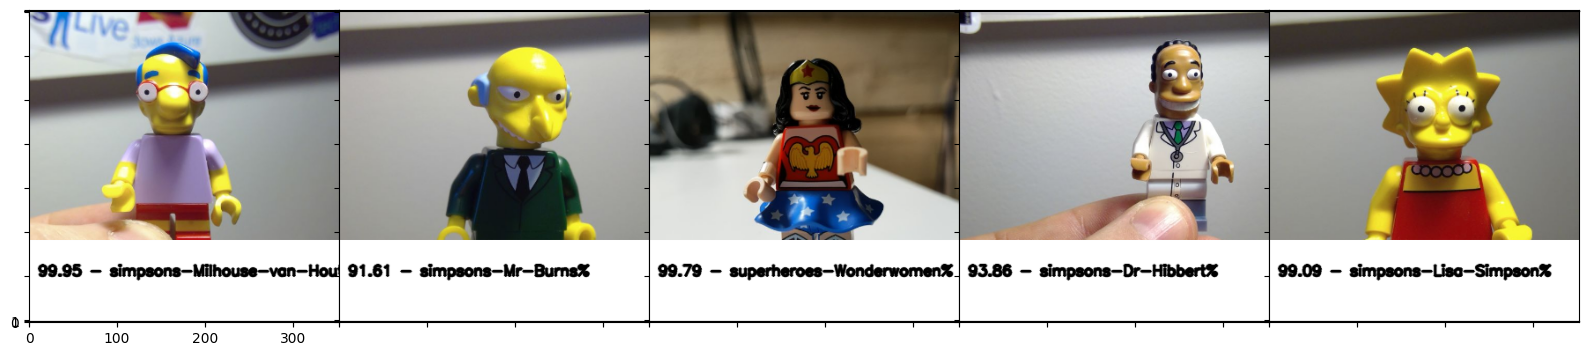

In [71]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import json
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import cv2
import random

# Loading the model
model = torch.load("model/Ignite-Lego-Classification/model/model.pth", map_location=lambda storage, loc: storage)
model.eval()

# Loading the labels    
with open("model/Ignite-Lego-Classification/model/labels.txt", 'rt') as lf:
    labels = [l.strip() for l in lf.readlines()]


def score(input_image):

    preprocess = transforms.Compose([
        transforms.Resize(225),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    index = output.data.cpu().numpy().argmax()
    probability = torch.nn.functional.softmax(output[0], dim=0).data.cpu().numpy().max()
  
    predictions = {}
    predictions[labels[index]] = str(round(probability*100,2))    

    return {
        'prediction': labels[index], 
        'score':  predictions[labels[index]]
    }

# Score 5 random images
path = r"./test-images"
grid = AxesGrid(plt.figure(1, (20,20)), 111, nrows_ncols=(4, 5), axes_pad=0, label_mode="1")

for img in random.sample(os.listdir(path),5):
    
    #Score the image
    input_image = Image.open(os.path.join(path,img))
    result = score(input_image)

    # Download image
    image = cv2.imread(os.path.join(path,img))
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image, (0,260),(352,352),(255,255,255), -1)
    cv2.putText(image, "{} - {}%".format(result['score'],result['prediction']),(10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.55,(0,0,0),2,cv2.LINE_AA)    
    
    # Show image in grid
    grid[i].imshow(image)
    i = i+1
